In [1]:
import sys

from qetu_sim import *

import numpy as np
import scipy.linalg
import itertools
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.transpiler import Layout
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import Permutation
from qiskit.visualization import *
from qiskit_aer import AerSimulator

In [2]:
u = 1
t = 1
delta_t = 1
n = 1
num_sites = 4

In [3]:
ref_H_matrix = ref_fh_hamiltonian(u=u, t=t)
ref_U_matrix = ref_fh_op(u=1, t=1, delta_t=1)

c:\Python311\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Python311\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [4]:
mat_step_func_02 = scipy.io.loadmat('../phase_angles/step_function_02.mat')['phi_proc']
step_function_02_qsp_angles = list(itertools.chain.from_iterable(mat_step_func_02))

mat_step_func_02_d50 = scipy.io.loadmat('../phase_angles/step_function_02_d80.mat')['phi_proc']
step_function_02_d50_qsp_angles = list(itertools.chain.from_iterable(mat_step_func_02_d50))

c:\Python311\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python311\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


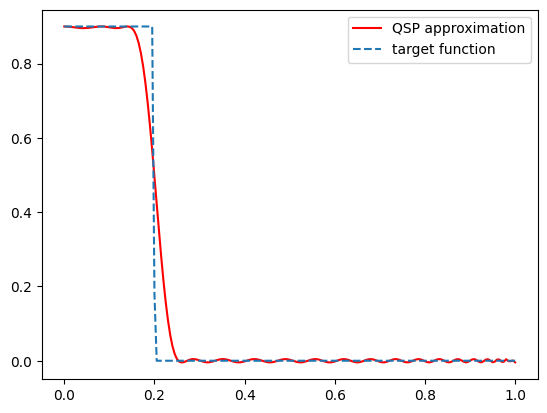

In [5]:
def target_heaviside(x, scale=1):
    """
        Target function for eigenvalue filtering.
    """
    return scale * np.heaviside(-x+0.2, 0.2)

x_vec = np.linspace(0, 1, 201)
y_vec = []
for x in x_vec:
    qsp_circuit = QSP(step_function_02_d50_qsp_angles, x)
    y = circuit2matrix(qsp_circuit)[0,0]
    y_vec.append(y)

plt.plot(x_vec, y_vec, "r", label="QSP approximation")
plt.plot(x_vec, target_heaviside(x_vec, scale=0.9), "--", label="target function")
plt.legend()

In [7]:
u = 1
t = 1
delta_t = 1
degree_list = range(6,101,2)
trotter_steps_list = range(1,2)
overlap_list = []
overlap_noise_list = []

for degree in degree_list:
    for trotter_steps in trotter_steps_list:
        print("Degree: " + str(degree) + "\t Trotter steps: " + str(trotter_steps))
        print("-------------------------")
        mat_step_func = scipy.io.loadmat('../phase_angles/step_function_02_d' + str(degree) + '.mat')['phi_proc']
        step_function_qsp_angles = list(itertools.chain.from_iterable(mat_step_func))
        phi_vec = convert_Zrot_to_Xrot(step_function_qsp_angles)
        QETU_circ = construct_QETU_circ(u, t, degree, trotter_steps, phi_vec)
        QETU_circ_WMI = transpile_QETU_to_WMI(QETU_circ)
        initial_state = Statevector.from_label("0-+0++++0")
        final_state = qetu_sim(QETU_circ_WMI, initial_state)
        ground_state_energy, ground_state_vector = calculate_reference_ground_state(u, t, True)
        success_probability = scipy.linalg.norm(final_state)**2
        overlap = abs(np.vdot(final_state / scipy.linalg.norm(final_state), ground_state_vector))**2
        print("overlap: " + str(overlap))
        noise_model = wmi_grid_noise_model()
        final_state_noise = qetu_sim_noise(QETU_circ_WMI, initial_state, noise_model)
        overlap_noise = abs(np.vdot(final_state_noise / scipy.linalg.norm(final_state_noise), ground_state_vector))**2
        print("overlap noise: " + str(overlap_noise))
        overlap_list.append(overlap)

Degree: 6	 Trotter steps: 1
-------------------------
overlap: 0.003127841494942586


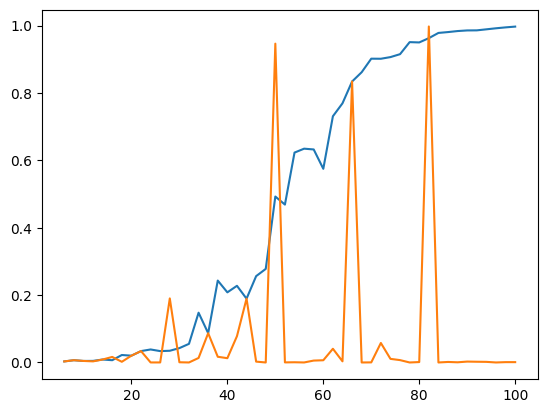

In [ ]:
plt.plot(degree_list, overlap_list)
plt.plot(degree_list, overlap_noise_list)